# Setting up a basic EasyVVUQ campaign

If this is your first Jupyter Notebook - you can execute code cells by selecting them and pressing ```Shift+Enter```. Just have in mind that the order of execution might matter (if later cells depend on things done in earlier ones).

**Note**: if you installed EasyVVUQ using a virtual environment, make sure that:

1) you activated the virtual environment, and
2) you started this notebook with `myenv/bin/jupyterlab`.

EasyVVUQ is a Python library designed to facilitate verification, validation and uncertainty quantification (VVUQ) for a wide variety of simulations. It was first conceived and developed within the EU funded [VECMA](https://www.vecma.eu/) (Verified Exascale Computing for Multiscale Applications) project, and further developed in the UK-funded [SEAVEA project](https://www.seavea-project.org/).

The aim of EasyVVUQ is to facilitate verification, validation and uncertainty quantification (VVUQ) for a wide variety of simulations. While very convenient for simple cases, EasyVVUQ is particularly well suited in situations where the simulations are computationally expensive, heterogeneous computing resources are necessary, the sampling space is very large or book-keeping is prohibitively complex. It coordinates execution using an efficient database, it is fault tolerant and all progress can be saved.

Here are some examples of questions EasyVVUQ can answer about your code:

* Given the uncertainties in input parameters, what is the distribution of the output?
* What percentage of the output variance each input parameter contributes?
* It also lets you construct surrogate models that are cheaper to evaluate than the complete simulation.

The functionality we will be focusing on in this tutorial are the Polynomials Chaos and Stochastic collocation samplers. We will test it out on the following advection diffusion equation:

\begin{align*}
\boxed{
\frac{du}{dx} - \frac{1}{Pe}\frac{d^2u}{dx^2} = f}
\end{align*}

This ODE solves for the velocity $u(x)$, where the spatial domain runs from $x\in[0,1]$. Homogeneous boundary conditions are applied: $u(0)=u(1)=0$. The solution $u$ depends upon two parameters:

* $Pe$: the so-called **Peclet number**, defined as the ratio between the rate of advection and the rate of diffusion,
* $f$: the constant forcing term.

A numerical solver (finite elements) of this equation is found in `advection_diffusion_model/advection_diffusion.py`.

**Note**: While we are using a Python UQ library on a Python ODE model, this does not need to be the case. Models written in other programming languages are supported as well. The only requirements of EasyVVUQ are:

* The model can be executed from the command line.
* The model reads its input values from a file.
* The model stores its output values to a (CSV / HDF5 / JSON) file.

The input file of our advection-diffusion model is a simple JSON file, but the particular format is not important. It is located in `advection_diffusion_model/input.json`. The input file looks like this:

In [1]:
with open('./advection_diffusion_model/input.json', 'r') as f:
    print(f.read())

{"Pe": "100",
 "f": "1"}



We can see that the default values of $Pe$ and $f$ are 100 and 1 respectively. Our goal now is:

**Study the effect of uncertainties in $Pe$ and $f$ on the velocity profile $u(x)$**

We require the following imports to do so:

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import chaospy as cp
import easyvvuq as uq
from easyvvuq.actions import CreateRunDirectory, Encode, Decode, ExecuteLocal, Actions

### Flags

Here are some flags that we'll use

* `HOME`: simply the current directory,
* `WORK_DIR`: this is where all the EasyVVUQ ensembles runs will be stored,
* `CAMPAIGN_NAME`: this is the name of the EasyVVUQ campaign, explained later.

In [3]:
# home directory
HOME = os.getcwd()
# Work directory, where the easyVVUQ directory will be placed
WORK_DIR = '/tmp'
# EasyVVUQ Campaign name
CAMPAIGN_NAME = 'adv_diff'

### Define parameter space

We will have to define a dictionary that minimally describes the type (typically `float` or maybe `integer`) of each input, as well as its default value. Below we create the `params` dict for the Peclet number $Pe$ and forcing term $f$.

In [4]:
# Define parameter space
params = {
    "Pe": {
        "type": "float",
        "default": 100.0},
    "f": {
        "type": "float",
        "default": 1.0}}

### Choose input distributions

Here we assign a probability density function to inputs from the `params` dict.  EasyVVUQ uses the [Chaospy](https://chaospy.readthedocs.io/en/master/) library for this purpose. A list of available distributions can be found [here](https://chaospy.readthedocs.io/en/master/reference/distribution/index.html).

All parameters that we actually want to vary are stored in the `vary`. These must also occur in the `params` dict. The converse is not true. If we only wish to vary a subset of the inputs in the `params` dict, we simply leave out the inputs in the `vary` dict that we do not want to change. These excluded inputs will automatically be assigned their default value in all ensemble runs.

**Assignment**: Assign uniform distribution to both inputs, using the `cp.Uniform` distribution, bounded to $\pm10\%$ of the defaults values:

In [5]:
vary = {'Pe' : cp.Uniform(0.9 * params['Pe']['default'], 1.1 * params['Pe']['default']),
        'f' :  cp.Uniform(0.9 * params['f']['default'], 1.1 * params['f']['default'])}
vary

{'Pe': Uniform(lower=90.0, upper=110.00000000000001),
 'f': Uniform(lower=0.9, upper=1.1)}

### Input file encoding

We require some way of feeding new parameter values to whatever simulation code we are examining. This is done by creating an **input template**. The `GenericEncoder` class can read this template and fill it with input samples drawn from the distributions of the `vary` dict. It takes 3 arguments:

* `template_fname` (string): the name of the input template
* `delimiter` (string): a flag sought out by the encoder
* `target_filename` (string): the name of the input file, in our case `input.json`

In the input template, every delimiter should be followed by a parameter name (the keys of `vary`), such that the encoder can replace each flag with a input value.

**Assignment**: 

* Set the delimiter to `$`
* Copy the input file `advection_diffusion_model/input.json` to `advection_diffusion_model/input.template`
* Change the default parameters in the template into flags that the encoder can read.
  

In [6]:
encoder = uq.encoders.GenericEncoder(template_fname='advection_diffusion_model/input.template',
                                     delimiter='$',
                                     target_filename='input.json')

### Local ensemble execution

Our advection-diffusion model is just a toy model that can be executed locally. For this purpose we can use the EasyVVUQ `ExecuteLocal` class. It simply takes as an argument the commandline execution as a string.

**Assigment**: write the proper commandline instruction, making sure you use an absolute path to the advection-diffusion model

In [7]:
execute = ExecuteLocal('python {}/advection_diffusion_model/advection_diffusion.py'.format(HOME))

### Output file decoding

The model write the solution $u(x)$ to a CSV output file `output.csv`, with a single column with header `u`:

In [8]:
# print output file
with open('./advection_diffusion_model/output.csv', 'r') as f:
    print(f.read())

u
-1.864008286347368119e-15
3.333333333331467852e-03
6.666666666664799665e-03
9.999999999998130176e-03
1.333333333333146069e-02
1.666666666666478946e-02
1.999999999999811651e-02
2.333333333333144355e-02
2.666666666666477406e-02
2.999999999999811151e-02
3.333333333333144549e-02
3.666666666666477947e-02
3.999999999999811345e-02
4.333333333333144743e-02
4.666666666666478142e-02
4.999999999999811540e-02
5.333333333333145632e-02
5.666666666666479030e-02
5.999999999999812428e-02
6.333333333333146520e-02
6.666666666666479224e-02
6.999999999999811928e-02
7.333333333333144632e-02
7.666666666666477337e-02
7.999999999999810041e-02
8.333333333333144133e-02
8.666666666666476837e-02
8.999999999999809541e-02
9.333333333333142245e-02
9.666666666666474950e-02
9.999999999999807654e-02
1.033333333333314036e-01
1.066666666666647306e-01
1.099999999999980715e-01
1.133333333333314125e-01
1.166666666666647534e-01
1.199999999999980804e-01
1.233333333333314075e-01
1.266666666666647345e-01
1.299999999999980616e-

To read the output, we will use the `SimpleCSV` decoder. It takes 2 arguments:

* `target_filename` (string): the name of the output file
* `output_columns` (list of strings): the column names of the CSV file that we wish to load

**Assignment**: Fill out the decoder arguments:

In [9]:
decoder = uq.decoders.SimpleCSV(target_filename='output.csv', 
                                output_columns=['u'])

**Note**: the encoder and decoder we have used will often suffice, yet are fairly basic. More elaborate encoders/decoders are available, see [here](https://github.com/UCL-CCS/EasyVVUQ/blob/dev/tutorials/encoder_decoder_tutorial.ipynb) for a tutorial. If you want to work with outputs of various sizes, you can use the `uq.decoder.HDF5` decoder, which takes the same arguments as the CSV decoder above.

### Actions: creating a sequence of steps

A typical forward UQ work flow consist of the following steps:

1) Create directories for the different runs in the ensemble
2) Encode the input files
3) Execute the ensemble
4) Decode the output
5) Perform postprocessing on the results

Steps 1-4 are strung together in an `Actions` objects as follows:

In [10]:
actions = Actions(CreateRunDirectory(WORK_DIR, flatten=True),
                  Encode(encoder), 
                  execute,
                  Decode(decoder))

These actions will be executed in a UQ Campaign

### Campaign: putting everything 

A campaign is the central EasyVVUQ object which combines all elements. It requires the working directory, a name, the `params` definition and the defined `actions`.

In [11]:
campaign = uq.Campaign(work_dir=WORK_DIR, name=CAMPAIGN_NAME,
                       params=params, actions=actions)

### Selecting a sampling method

The sampling method is added seperately to the campaign. It this case we use a Polynomial Chaos sampler.

**Question**: the polynomial order is set to 3. How many times will we sample the advection-diffusion model?

In [12]:
sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)
campaign.set_sampler(sampler)

### Executing the actions

Finally, to executed everything that we defined in `actions`, run the following command:

In [13]:
campaign.execute().collate()

-----/tmp/adv_diff662qk3xe/runs/run_1
Solving advection diffusion equation at Pe = 91.4 and f = 0.9
-----/tmp/adv_diff662qk3xe/runs/run_7
Solving advection diffusion equation at Pe = 96.6 and f = 1.0
-----/tmp/adv_diff662qk3xe/runs/run_11
Solving advection diffusion equation at Pe = 103.4 and f = 1.0
-----/tmp/adv_diff662qk3xe/runs/run_5
Solving advection diffusion equation at Pe = 96.6 and f = 0.9
-----/tmp/adv_diff662qk3xe/runs/run_10
Solving advection diffusion equation at Pe = 103.4 and f = 1.0
-----/tmp/adv_diff662qk3xe/runs/run_3
Solving advection diffusion equation at Pe = 91.4 and f = 1.0
-----/tmp/adv_diff662qk3xe/runs/run_2
Solving advection diffusion equation at Pe = 91.4 and f = 1.0
-----/tmp/adv_diff662qk3xe/runs/run_6
Solving advection diffusion equation at Pe = 96.6 and f = 1.0
-----/tmp/adv_diff662qk3xe/runs/run_12
Solving advection diffusion equation at Pe = 103.4 and f = 1.1
-----/tmp/adv_diff662qk3xe/runs/run_8
Solving advection diffusion equation at Pe = 96.6 and f 

### Retrieving the raw results

The raw results are stored in a Pandas dataframe. We can retrieve this via:

In [14]:
df = campaign.get_collation_result()
df

run_id iteration          Pe         f             u                      \
      0         0           0         0             0         1         2     
0       1         0   91.388637  0.913886  1.202851e-14  0.002285  0.004569   
1       2         0   91.388637  0.966002  2.776896e-14  0.002415  0.004830   
2       3         0   91.388637  1.033998  1.033529e-14  0.002585  0.005170   
3       4         0   91.388637  1.086114  2.637404e-14  0.002715  0.005431   
4       5         0   96.600190  0.913886  6.126804e-15  0.002285  0.004569   
5       6         0   96.600190  0.966002  3.435850e-15  0.002415  0.004830   
6       7         0   96.600190  1.033998  6.409849e-15  0.002585  0.005170   
7       8         0   96.600190  1.086114  5.013566e-15  0.002715  0.005431   
8       9         0  103.399810  0.913886 -5.493630e-15  0.002285  0.004569   
9      10         0  103.399810  0.966002 -9.503442e-15  0.002415  0.004830   
10     11         0  103.399810  1.033998  2.179103e-15  0.002585  0.005170   
11     12         0  103.399810  1.086114  2.730609e-16  0.002715  0.005431   
12     13         0  108.611363  0.913886  9.934322e-16  0.002285  0.004569   
13     14         0  108.611363  0.966002 -6.807030e-15  0.002415  0.004830   
14     15         0  108.611363  1.033998  3.137844e-15  0.002585  0.005170   
15     16         0  108.611363  1.086114  4.322144e-15  0.002715  0.005431   

                                  ...                                          \
         3         4         5    ...       391       392       393       394   
0   0.006854  0.009139  0.011424  ...  0.777456  0.749855  0.714544  0.669536   
1   0.007245  0.009660  0.012075  ...  0.821792  0.792616  0.755292  0.707717   
2   0.007755  0.010340  0.012925  ...  0.879637  0.848408  0.808456  0.757533   
3   0.008146  0.010861  0.013576  ...  0.923973  0.891169  0.849204  0.795714   
4   0.006854  0.009139  0.011424  ...  0.790446  0.764473  0.730740  0.687113   
5   0.007245  0.009660  0.012075  ...  0.835522  0.808068  0.772411  0.726296   
6   0.007755  0.010340  0.012925  ...  0.894334  0.864948  0.826780  0.777420   
7   0.008146  0.010861  0.013576  ...  0.939410  0.908543  0.868452  0.816603   
8   0.006854  0.009139  0.011424  ...  0.805255  0.781394  0.749772  0.708084   
9   0.007245  0.009660  0.012075  ...  0.851175  0.825954  0.792529  0.748463   
10  0.007755  0.010340  0.012925  ...  0.911089  0.884093  0.848314  0.801147   
11  0.008146  0.010861  0.013576  ...  0.957010  0.928653  0.891071  0.841527   
12  0.006854  0.009139  0.011424  ...  0.815163  0.792891  0.762904  0.722777   
13  0.007245  0.009660  0.012075  ...  0.861649  0.838107  0.806409  0.763994   
14  0.007755  0.010340  0.012925  ...  0.922300  0.897100  0.863172  0.817771   
15  0.008146  0.010861  0.013576  ...  0.968785  0.942316  0.906677  0.858988   

                                                           
         395       396       397       398       399  400  
0   0.612330  0.539778  0.447924  0.331787  0.185106  0.0  
1   0.647249  0.570560  0.473467  0.350708  0.195662  0.0  
2   0.692808  0.610721  0.506794  0.375394  0.209434  0.0  
3   0.727727  0.641503  0.532338  0.394315  0.219990  0.0  
4   0.630876  0.558564  0.465764  0.346847  0.194641  0.0  
5   0.666852  0.590417  0.492325  0.366627  0.205740  0.0  
6   0.713791  0.631976  0.526979  0.392433  0.220222  0.0  
7   0.749768  0.663829  0.553540  0.412213  0.231322  0.0  
8   0.653342  0.581670  0.488043  0.365942  0.206915  0.0  
9   0.690600  0.614841  0.515874  0.386811  0.218715  0.0  
10  0.739210  0.658119  0.552186  0.414038  0.234110  0.0  
11  0.776468  0.691289  0.580017  0.434906  0.245910  0.0  
12  0.669325  0.598362  0.504385  0.380165  0.216199  0.0  
13  0.707494  0.632484  0.533148  0.401844  0.228528  0.0  
14  0.757294  0.677004  0.570676  0.430130  0.244614  0.0  
15  0.795463  0.711127  0.599440  0.451809  0.256943  0.0  

[16 rows x 405 columns]

### Analysis: postprocessing the results

The following command runs the prost-processing subroutines

In [20]:
results = campaign.analyse(qoi_cols=['u'])

Error LinAlgError for u


/home/wouter/py-env/lib/python3.9/site-packages/chaospy/descriptives/correlation/pearson.py:46: RuntimeWarning: invalid value encountered in divide
  return numpy.where(vvar > 0, cov/vvar, 0)


Getting code samples:

In [21]:
# advection diffusion runs
code_samples = results.samples['u'].values
# spatial domain of 1 run
xx = np.linspace(0, 1, code_samples.shape[1])

### Plotting moments

The following command show a list of suppported statistics:

In [22]:
results.supported_stats()

['min', 'max', '10%', '90%', '1%', '99%', 'median', 'mean', 'var', 'std']

**Assignment**: using `results.describe(qoi = <output name>, statistic = <stat name>)` extract the mean and standard deviation. Use this to make a plot of the uncertainty around the mean, as a function of the spatial domain `xx`.

**Question**: This is a common way of visualizing the uncertainty. Is it always a good idea?

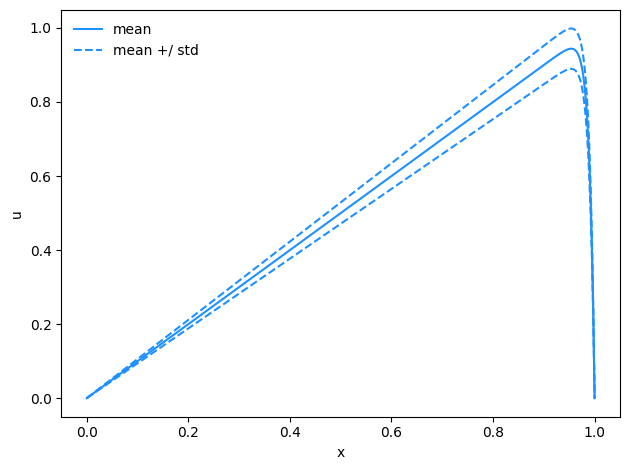

In [17]:
mean = results.describe(qoi = 'u', statistic = 'mean')
std = results.describe(qoi = 'u', statistic = 'std')

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel = 'u')
ax.plot(xx, mean, color='dodgerblue', label='mean')
ax.plot(xx, mean + std, '--', color='dodgerblue', label='mean +/ std')
ax.plot(xx, mean - std, '--', color='dodgerblue')
plt.legend(frameon = False)
plt.tight_layout()
plt.tight_layout()

### Fast sampling using the surrogate

The command below extracts the (PCE) expansion, which can be used as a surrogate model for the real code.

**Assignment**: create a `random_inputs` dictionary `{'Pe': 1000 random Pe samples, 'f': 1000 random f samples}`. You can sample the inputs by `vary['Pe'].sample(1000)`.

Feed these random inputs to the surrogate and plot the surrogate samples alongside the real code samples, which were extracted above. Does the surrogate provide decent looking samples?

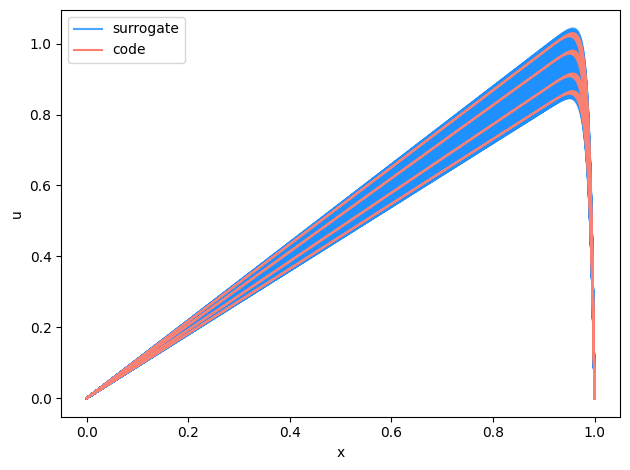

In [18]:
surrogate = results.surrogate()

random_inputs = {}
n_samples = 1000
for param in vary.keys():
    random_inputs[param] = vary[param].sample(n_samples)

u_surrogate = surrogate(random_inputs)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel = 'u')
ax.plot(xx, np.array(u_surrogate['u']).T, color='dodgerblue', alpha=0.8, label='surrogate')
ax.plot(xx, code_samples.T, color='salmon', label='code')

# legend, but remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()

### Plotting the Sobol indices

The command below will extract the first-order Sobol indices.

**Assigment**: Plot these in the spatial domain. What can you conclude about the importance of `Pe`?

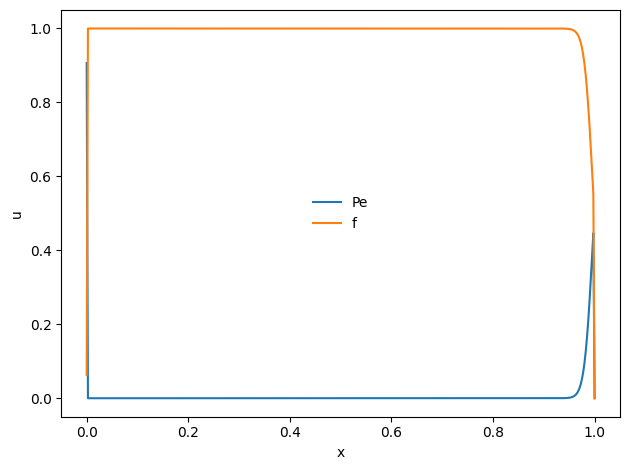

In [19]:
sobols_first = results.sobols_first()

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel = 'u')

for param in vary:
    ax.plot(xx, sobols_first['u'][param], label=param)

plt.legend(frameon = False)
plt.tight_layout()

### Switching samplers

**Assignment**: Repeat the analysis, except this time with the Stochastic Collocation sampler. Hint: don't overcomplicate, you could complete this assignment in 30 seconds or less.